In [574]:
import pandas as pd
import numpy as np



In [575]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import *



pd.set_option('display.max_columns', None)

In [576]:
weather_energy = pd.read_csv('final.csv')
weather_energy.set_index('day',inplace=True)
weather_energy.shape

(827, 15)

In [577]:
weather_energy.head()

,avg_energy,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,WindGustKmph,cloudcover,humidity,precipMM,pressure,visibility,winddirDegree,IsBankHoliday
day,,,,,,,,,,,,,,,
2011-11-23,6.952692,10.0,5.0,0.0,8.7,2.0,16.0,18.0,25.0,90.0,0.0,1027,7.0,257,0
2011-11-24,8.536480,13.0,8.0,0.0,8.7,3.0,9.0,30.0,45.0,92.0,0.0,1028,10.0,205,0
2011-11-25,9.499781,12.0,7.0,0.0,8.7,2.0,2.0,31.0,44.0,87.0,0.2,1024,9.0,240,0
2011-11-26,10.267707,12.0,6.0,0.0,8.2,3.0,5.0,35.0,30.0,90.0,0.0,1026,10.0,229,1
2011-11-27,10.850805,12.0,6.0,0.0,6.8,3.0,11.0,36.0,38.0,85.0,0.3,1021,10.0,258,1


In [578]:
weather_energy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 827 entries, 2011-11-23 to 2014-02-26
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_energy         827 non-null    float64
 1   maxtempC           827 non-null    float64
 2   mintempC           827 non-null    float64
 3   totalSnow_cm       827 non-null    float64
 4   sunHour            827 non-null    float64
 5   uvIndex            827 non-null    float64
 6   moon_illumination  827 non-null    float64
 7   WindGustKmph       827 non-null    float64
 8   cloudcover         827 non-null    float64
 9   humidity           827 non-null    float64
 10  precipMM           827 non-null    float64
 11  pressure           827 non-null    int64  
 12  visibility         827 non-null    float64
 13  winddirDegree      827 non-null    int64  
 14  IsBankHoliday      827 non-null    int64  
dtypes: float64(12), int64(3)
memory usage: 103.4+ KB


In [579]:
#function to convert time series data to apply supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [580]:
from sklearn.preprocessing import MinMaxScaler

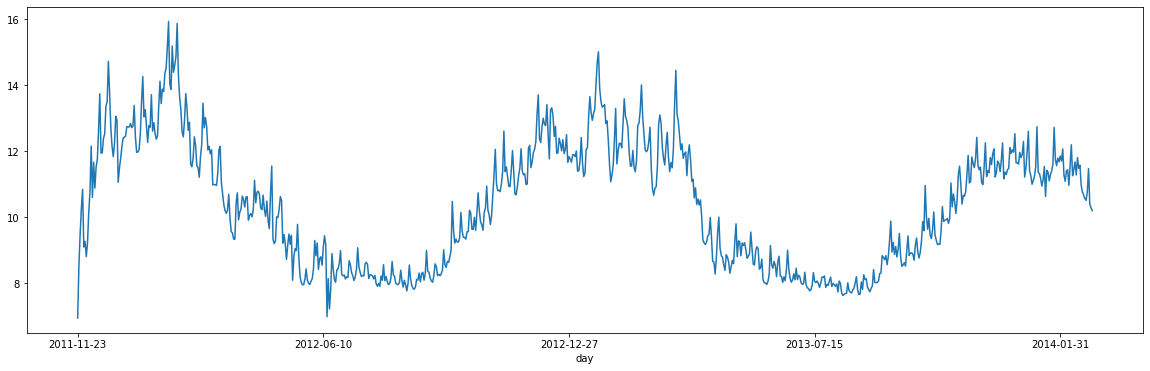

In [581]:
weather_energy["avg_energy"].plot(figsize=(20,6));


In [582]:
weather_energy.shape

(827, 15)

In [583]:
weather_energy.head()


,avg_energy,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,WindGustKmph,cloudcover,humidity,precipMM,pressure,visibility,winddirDegree,IsBankHoliday
day,,,,,,,,,,,,,,,
2011-11-23,6.952692,10.0,5.0,0.0,8.7,2.0,16.0,18.0,25.0,90.0,0.0,1027,7.0,257,0
2011-11-24,8.536480,13.0,8.0,0.0,8.7,3.0,9.0,30.0,45.0,92.0,0.0,1028,10.0,205,0
2011-11-25,9.499781,12.0,7.0,0.0,8.7,2.0,2.0,31.0,44.0,87.0,0.2,1024,9.0,240,0
2011-11-26,10.267707,12.0,6.0,0.0,8.2,3.0,5.0,35.0,30.0,90.0,0.0,1026,10.0,229,1
2011-11-27,10.850805,12.0,6.0,0.0,6.8,3.0,11.0,36.0,38.0,85.0,0.3,1021,10.0,258,1


In [584]:
weather_energy.tail()

,avg_energy,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,WindGustKmph,cloudcover,humidity,precipMM,pressure,visibility,winddirDegree,IsBankHoliday
day,,,,,,,,,,,,,,,
2014-02-22,10.776242,10.0,3.0,0.0,10.3,3.0,48.0,32.0,27.0,84.0,0.0,1009,10.0,223,1
2014-02-23,11.480411,12.0,6.0,0.0,6.9,2.0,42.0,44.0,66.0,91.0,0.3,1011,9.0,186,1
2014-02-24,10.411403,13.0,6.0,0.0,8.5,2.0,35.0,35.0,44.0,85.0,0.1,1006,10.0,175,0
2014-02-25,10.294997,10.0,5.0,0.0,10.0,2.0,28.0,34.0,54.0,87.0,1.1,1001,9.0,186,0
2014-02-26,10.202945,10.0,3.0,0.0,10.8,3.0,21.0,24.0,14.0,85.0,0.5,1012,9.0,224,0


In [585]:
no_of_timesteps=6
no_of_timesteps_lead=2
reframed = series_to_supervised(weather_energy.values, no_of_timesteps,no_of_timesteps_lead)
reframed

,var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var7(t-6),var8(t-6),var9(t-6),var10(t-6),var11(t-6),var12(t-6),var13(t-6),var14(t-6),var15(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var9(t-5),var10(t-5),var11(t-5),var12(t-5),var13(t-5),var14(t-5),var15(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var7(t-4),var8(t-4),var9(t-4),var10(t-4),var11(t-4),var12(t-4),var13(t-4),var14(t-4),var15(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),var11(t-3),var12(t-3),var13(t-3),var14(t-3),var15(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),var11(t-2),var12(t-2),var13(t-2),var14(t-2),var15(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t),var15(t),var1(t+1),var2(t+1),var3(t+1),var4(t+1),var5(t+1),var6(t+1),var7(t+1),var8(t+1),var9(t+1),var10(t+1),var11(t+1),var12(t+1),var13(t+1),var14(t+1),var15(t+1)
6,6.952692,10.0,5.0,0.0,8.7,2.0,16.0,18.0,25.0,90.0,0.0,1027.0,7.0,257.0,0.0,8.536480,13.0,8.0,0.0,8.7,3.0,9.0,30.0,45.0,92.0,0.0,1028.0,10.0,205.0,0.0,9.499781,12.0,7.0,0.0,8.7,2.0,2.0,31.0,44.0,87.0,0.2,1024.0,9.0,240.0,0.0,10.267707,12.0,6.0,0.0,8.2,3.0,5.0,35.0,30.0,90.0,0.0,1026.0,10.0,229.0,1.0,10.850805,12.0,6.0,0.0,6.8,3.0,11.0,36.0,38.0,85.0,0.30,1021.0,10.0,258.0,1.0,9.103382,10.0,5.0,0.0,8.2,3.0,18.0,20.0,36.0,87.0,0.10,1023.0,10.0,197.0,0.0,9.274873,13.0,7.0,0.0,3.1,3.0,25.0,40.0,80.0,90.0,0.50,1010.0,9.0,205.0,0.0,8.813513,11.0,5.0,0.0,6.8,2.0,32.0,32.0,33.0,85.0,0.00,1019.0,10.0,205.0,0.0
7,8.536480,13.0,8.0,0.0,8.7,3.0,9.0,30.0,45.0,92.0,0.0,1028.0,10.0,205.0,0.0,9.499781,12.0,7.0,0.0,8.7,2.0,2.0,31.0,44.0,87.0,0.2,1024.0,9.0,240.0,0.0,10.267707,12.0,6.0,0.0,8.2,3.0,5.0,35.0,30.0,90.0,0.0,1026.0,10.0,229.0,1.0,10.850805,12.0,6.0,0.0,6.8,3.0,11.0,36.0,38.0,85.0,0.3,1021.0,10.0,258.0,1.0,9.103382,10.0,5.0,0.0,8.2,3.0,18.0,20.0,36.0,87.0,0.10,1023.0,10.0,197.0,0.0,9.274873,13.0,7.0,0.0,3.1,3.0,25.0,40.0,80.0,90.0,0.50,1010.0,9.0,205.0,0.0,8.813513,11.0,5.0,0.0,6.8,2.0,32.0,32.0,33.0,85.0,0.00,1019.0,10.0,205.0,0.0,9.227707,11.0,5.0,0.0,4.9,2.0,39.0,25.0,78.0,90.0,7.25,1007.0,9.0,143.0,0.0
8,9.499781,12.0,7.0,0.0,8.7,2.0,2.0,31.0,44.0,87.0,0.2,1024.0,9.0,240.0,0.0,10.267707,12.0,6.0,0.0,8.2,3.0,5.0,35.0,30.0,90.0,0.0,1026.0,10.0,229.0,1.0,10.850805,12.0,6.0,0.0,6.8,3.0,11.0,36.0,38.0,85.0,0.3,1021.0,10.0,258.0,1.0,9.103382,10.0,5.0,0.0,8.2,3.0,18.0,20.0,36.0,87.0,0.1,1023.0,10.0,197.0,0.0,9.274873,13.0,7.0,0.0,3.1,3.0,25.0,40.0,80.0,90.0,0.50,1010.0,9.0,205.0,0.0,8.813513,11.0,5.0,0.0,6.8,2.0,32.0,32.0,33.0,85.0,0.00,1019.0,10.0,205.0,0.0,9.227707,11.0,5.0,0.0,4.9,2.0,39.0,25.0,78.0,90.0,7.25,1007.0,9.0,143.0,0.0,10.145910,7.0,3.0,0.0,8.1,2.0,45.0,21.0,35.0,91.0,7.25,1012.0,9.0,254.0,0.0
9,10.267707,12.0,6.0,0.0,8.2,3.0,5.0,35.0,30.0,90.0,0.0,1026.0,10.0,229.0,1.0,10.850805,12.0,6.0,0.0,6.8,3.0,11.0,36.0,38.0,85.0,0.3,1021.0,10.0,258.0,1.0,9.103382,10.0,5.0,0.0,8.2,3.0,18.0,20.0,36.0,87.0,0.1,1023.0,10.0,197.0,0.0,9.274873,13.0,7.0,0.0,3.1,3.0,25.0,40.0,80.0,90.0,0.5,1010.0,9.0,205.0,0.0,8.813513,11.0,5.0,0.0,6.8,2.0,32.0,32.0,33.0,85.0,0.00,1019.0,10.0,205.0,0.0,9.227707,11.0,5.0,0.0,4.9,2.0,39.0,25.0,78.0,90.0,7.25,1007.0,9.0,143.0,0.0,10.145910,7.0,3.0,0.0,8.1,2.0,45.0,21.0,35.0,91.0,7.25,1012.0,9.0,254.0,0.0,10.780273,10.0,6.0,0.0,4.9,2.0,52.0,36.0,60.0,91.0,7.25,1004.0,9.0,240.0,1.0
10,10.850805,12.0,6.0,0.0,6.8,3.0,11.0,36.0,38.0,85.0,0.3,1021.0,10.0,258.0,1.0,9.103382,10.0,5.0,0.0,8.2,3.0,18.0,20.0,36.0,87.0,0.1,1023.0,10.0,197.0,0.0,9.274873,13.0,7.0,0.0,3.1,3.0,25.0,40.0,80.0,90.0,0.5,1010.0,9.0,205.0,0.0,8.813513,11.0,5.0,0.0,6.8,2.0,32.0,32.0,33.0,85.0,0.0,1019.0,10.0,205.0,0.0,9.227707,11.0,5.0,0.0,4.9,2.0,39

In [586]:
reframed[454:][['var1(t-1)','var1(t)','var1(t+1)']]

,var1(t-1),var1(t),var1(t+1)
460,14.014282,13.059055,12.573332
461,13.059055,12.573332,12.058759
462,12.573332,12.058759,11.990561
463,12.058759,11.990561,12.048499
464,11.990561,12.048499,12.308851
...,...,...,...
821,10.573835,10.518126,10.776242
822,10.518126,10.776242,11.480411
823,10.776242,11.480411,10.411403
824,11.480411,10.411403,10.294997


In [587]:
reframed= reframed.reset_index(drop=True)
reframed

,var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var7(t-6),var8(t-6),var9(t-6),var10(t-6),var11(t-6),var12(t-6),var13(t-6),var14(t-6),var15(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var9(t-5),var10(t-5),var11(t-5),var12(t-5),var13(t-5),var14(t-5),var15(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var7(t-4),var8(t-4),var9(t-4),var10(t-4),var11(t-4),var12(t-4),var13(t-4),var14(t-4),var15(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),var11(t-3),var12(t-3),var13(t-3),var14(t-3),var15(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),var11(t-2),var12(t-2),var13(t-2),var14(t-2),var15(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t),var15(t),var1(t+1),var2(t+1),var3(t+1),var4(t+1),var5(t+1),var6(t+1),var7(t+1),var8(t+1),var9(t+1),var10(t+1),var11(t+1),var12(t+1),var13(t+1),var14(t+1),var15(t+1)
0,6.952692,10.0,5.0,0.0,8.7,2.0,16.0,18.0,25.0,90.0,0.0,1027.0,7.0,257.0,0.0,8.536480,13.0,8.0,0.0,8.7,3.0,9.0,30.0,45.0,92.0,0.0,1028.0,10.0,205.0,0.0,9.499781,12.0,7.0,0.0,8.7,2.0,2.0,31.0,44.0,87.0,0.2,1024.0,9.0,240.0,0.0,10.267707,12.0,6.0,0.0,8.2,3.0,5.0,35.0,30.0,90.0,0.0,1026.0,10.0,229.0,1.0,10.850805,12.0,6.0,0.0,6.8,3.0,11.0,36.0,38.0,85.0,0.30,1021.0,10.0,258.0,1.0,9.103382,10.0,5.0,0.0,8.2,3.0,18.0,20.0,36.0,87.0,0.10,1023.0,10.0,197.0,0.0,9.274873,13.0,7.0,0.0,3.1,3.0,25.0,40.0,80.0,90.0,0.50,1010.0,9.0,205.0,0.0,8.813513,11.0,5.0,0.0,6.8,2.0,32.0,32.0,33.0,85.0,0.00,1019.0,10.0,205.0,0.0
1,8.536480,13.0,8.0,0.0,8.7,3.0,9.0,30.0,45.0,92.0,0.0,1028.0,10.0,205.0,0.0,9.499781,12.0,7.0,0.0,8.7,2.0,2.0,31.0,44.0,87.0,0.2,1024.0,9.0,240.0,0.0,10.267707,12.0,6.0,0.0,8.2,3.0,5.0,35.0,30.0,90.0,0.0,1026.0,10.0,229.0,1.0,10.850805,12.0,6.0,0.0,6.8,3.0,11.0,36.0,38.0,85.0,0.3,1021.0,10.0,258.0,1.0,9.103382,10.0,5.0,0.0,8.2,3.0,18.0,20.0,36.0,87.0,0.10,1023.0,10.0,197.0,0.0,9.274873,13.0,7.0,0.0,3.1,3.0,25.0,40.0,80.0,90.0,0.50,1010.0,9.0,205.0,0.0,8.813513,11.0,5.0,0.0,6.8,2.0,32.0,32.0,33.0,85.0,0.00,1019.0,10.0,205.0,0.0,9.227707,11.0,5.0,0.0,4.9,2.0,39.0,25.0,78.0,90.0,7.25,1007.0,9.0,143.0,0.0
2,9.499781,12.0,7.0,0.0,8.7,2.0,2.0,31.0,44.0,87.0,0.2,1024.0,9.0,240.0,0.0,10.267707,12.0,6.0,0.0,8.2,3.0,5.0,35.0,30.0,90.0,0.0,1026.0,10.0,229.0,1.0,10.850805,12.0,6.0,0.0,6.8,3.0,11.0,36.0,38.0,85.0,0.3,1021.0,10.0,258.0,1.0,9.103382,10.0,5.0,0.0,8.2,3.0,18.0,20.0,36.0,87.0,0.1,1023.0,10.0,197.0,0.0,9.274873,13.0,7.0,0.0,3.1,3.0,25.0,40.0,80.0,90.0,0.50,1010.0,9.0,205.0,0.0,8.813513,11.0,5.0,0.0,6.8,2.0,32.0,32.0,33.0,85.0,0.00,1019.0,10.0,205.0,0.0,9.227707,11.0,5.0,0.0,4.9,2.0,39.0,25.0,78.0,90.0,7.25,1007.0,9.0,143.0,0.0,10.145910,7.0,3.0,0.0,8.1,2.0,45.0,21.0,35.0,91.0,7.25,1012.0,9.0,254.0,0.0
3,10.267707,12.0,6.0,0.0,8.2,3.0,5.0,35.0,30.0,90.0,0.0,1026.0,10.0,229.0,1.0,10.850805,12.0,6.0,0.0,6.8,3.0,11.0,36.0,38.0,85.0,0.3,1021.0,10.0,258.0,1.0,9.103382,10.0,5.0,0.0,8.2,3.0,18.0,20.0,36.0,87.0,0.1,1023.0,10.0,197.0,0.0,9.274873,13.0,7.0,0.0,3.1,3.0,25.0,40.0,80.0,90.0,0.5,1010.0,9.0,205.0,0.0,8.813513,11.0,5.0,0.0,6.8,2.0,32.0,32.0,33.0,85.0,0.00,1019.0,10.0,205.0,0.0,9.227707,11.0,5.0,0.0,4.9,2.0,39.0,25.0,78.0,90.0,7.25,1007.0,9.0,143.0,0.0,10.145910,7.0,3.0,0.0,8.1,2.0,45.0,21.0,35.0,91.0,7.25,1012.0,9.0,254.0,0.0,10.780273,10.0,6.0,0.0,4.9,2.0,52.0,36.0,60.0,91.0,7.25,1004.0,9.0,240.0,1.0
4,10.850805,12.0,6.0,0.0,6.8,3.0,11.0,36.0,38.0,85.0,0.3,1021.0,10.0,258.0,1.0,9.103382,10.0,5.0,0.0,8.2,3.0,18.0,20.0,36.0,87.0,0.1,1023.0,10.0,197.0,0.0,9.274873,13.0,7.0,0.0,3.1,3.0,25.0,40.0,80.0,90.0,0.5,1010.0,9.0,205.0,0.0,8.813513,11.0,5.0,0.0,6.8,2.0,32.0,32.0,33.0,85.0,0.0,1019.0,10.0,205.0,0.0,9.227707,11.0,5.0,0.0,4.9,2.0,39.

In [588]:
reframed.head()["var1(t)"]

0     9.274873
1     8.813513
2     9.227707
3    10.145910
4    10.780273
Name: var1(t), dtype: float64

In [589]:
# drop columns we don't want to predict
we_le = len(weather_energy.columns)
col_array=np.arange(0,len(reframed.columns))
reframed=reframed.loc[:,(col_array<we_le*no_of_timesteps+we_le) | (col_array%(we_le)==0)]


In [590]:
reframed.shape

(820, 106)

In [591]:
reframed[:454]['var1(t)']

0       9.274873
1       8.813513
2       9.227707
3      10.145910
4      10.780273
         ...    
449    11.727896
450    12.791991
451    12.856232
452    13.245570
453    14.014282
Name: var1(t), Length: 454, dtype: float64

In [592]:
reframed[454:]['var1(t)']

454    13.059055
455    12.573332
456    12.058759
457    11.990561
458    12.048499
         ...    
815    10.518126
816    10.776242
817    11.480411
818    10.411403
819    10.294997
Name: var1(t), Length: 366, dtype: float64

In [593]:
# reframed.drop(['var1(t)','var1(t+1)','var1(t+2)','var1(t+3)','var1(t+4)','var1(t+5)'],axis=1,inplace=True)

In [594]:
n_train_time = 454; # hours used for training.....
original_n_train_time=n_train_time;
pred_list=[]; #predicted values that will replace the original test_y values
testing_rows=366;
#testing_rows=reframed.shape[0]-original_n_train_time-1
test1 = reframed.values[n_train_time:n_train_time+testing_rows, :] #original testing data, this will later be modified with the predicted data generated by for loop
test_y1 = test1[:, -1] #see comment in above line
batch_size_fit=1
train = reframed.values[:n_train_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test1[:, :-1], test1[:, -1]
# reshape input to be 3D [samples, timesteps, features]


In [595]:
reframed[:454]['var1(t)']

0       9.274873
1       8.813513
2       9.227707
3      10.145910
4      10.780273
         ...    
449    11.727896
450    12.791991
451    12.856232
452    13.245570
453    14.014282
Name: var1(t), Length: 454, dtype: float64

In [596]:
reframed[['var1(t-1)','var1(t)','var1(t+1)']]

,var1(t-1),var1(t),var1(t+1)
0,9.103382,9.274873,8.813513
1,9.274873,8.813513,9.227707
2,8.813513,9.227707,10.145910
3,9.227707,10.145910,10.780273
4,10.145910,10.780273,12.163127
...,...,...,...
815,10.573835,10.518126,10.776242
816,10.518126,10.776242,11.480411
817,10.776242,11.480411,10.411403
818,11.480411,10.411403,10.294997


In [597]:
reframed[454:464][['var1(t-1)','var1(t)','var1(t+1)']]

,var1(t-1),var1(t),var1(t+1)
454,14.014282,13.059055,12.573332
455,13.059055,12.573332,12.058759
456,12.573332,12.058759,11.990561
457,12.058759,11.990561,12.048499
458,11.990561,12.048499,12.308851
459,12.048499,12.308851,12.735907
460,12.308851,12.735907,11.481859
461,12.735907,11.481859,10.860481
462,11.481859,10.860481,10.675248
463,10.860481,10.675248,10.889469


In [598]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# train_X = scaler.fit_transform(train_X)
# #train_X = train_X.reshape((train_X.shape[0], no_of_timesteps, we_le))

# print(train_X.shape)

In [599]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
model = model = LinearRegression()
# fit LR model
model.fit(train_X, train_y)

LinearRegression()

In [600]:
y_true = []
for j in range(0,testing_rows):
    print('Loop # ',j)
    print(reframed.values[n_train_time,(len(reframed.columns)-1-we_le)])
    test = reframed.values[n_train_time:n_train_time+1, :]
    test_X = test[:, :-1]
    test_y = test[:, -1]
    
    print("check test x--->")
    print(reframed[n_train_time:n_train_time+1])
    print("check test ends x --->")
#     test_X = scaler.transform(test_X)
    #test_X = test_X.reshape((test_X.shape[0], no_of_timesteps, we_le))
    yhat = model.predict(test_X)
    if n_train_time+1<len(reframed):
        for k in range(0,len(reframed.columns),we_le):
            if((k+we_le)<(len(reframed.columns)-1)):
                reframed.values[n_train_time+1,k]=reframed.values[n_train_time,(k+we_le)];
        print('starts here')
        print(n_train_time+1,(len(reframed.columns)-1-we_le))
        print(reframed.values[n_train_time+1,(len(reframed.columns)-1-we_le)])
        print('ends here')
        reframed.values[n_train_time+1,(len(reframed.columns)-1-we_le)]=yhat;
        print('starts here')
        print(n_train_time+1,(len(reframed.columns)-1-we_le))
        print(reframed.values[n_train_time+1,(len(reframed.columns)-1-we_le)])
        print('ends here')
    #     reframed.values[n_train_time+1,0]=yhat;
    n_train_time=n_train_time+1
    pred_list=np.append(pred_list,yhat)
    y_true=np.append(y_true,test_y)
    print(reframed[n_train_time-1:n_train_time])
    print(yhat)
n_train_time=original_n_train_time

Loop #  0
13.05905549357143
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
454  11.385007       10.0        0.0        0.0       10.2        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
454       59.0        9.0       20.0        81.0         0.0      1019.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
454        10.0       171.0         0.0  11.727896        4.0       -1.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
454        0.0        8.4        1.0       66.0       27.0       45.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
454        87.0         0.3      1023.0         7.0        75.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
454  12.791991        3.0       -2.0        0.0       10.0        2.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4) 

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
457  12.856232        3.0       -2.0        0.3        8.4        1.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
457       80.0       27.0       47.0        70.0         0.3      1021.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
457        10.0        36.0         0.0   13.24557        2.0       -2.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
457        0.2        5.4        1.0       86.0       24.0       83.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
457        73.0         0.2      1021.0        10.0       109.0         1.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
457  14.014282        3.0       -3.0        0.2        6.9        1.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
457       93.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
463  12.512011        8.0        1.0        0.0        8.5        1.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
463       80.0       25.0       60.0        87.0         1.8      1030.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
463        10.0        36.0         0.0  12.227335        8.0        1.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
463        0.0        5.5        2.0       73.0       21.0       73.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
463        85.0         0.6      1029.0         8.0        32.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
463  12.513102        7.0        0.0        0.0       11.0        1.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
463       66.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
470  11.888692        9.0        7.0        0.0        5.6        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
470       32.0       17.0       99.0        93.0        7.25       997.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
470         8.0        85.0         0.0  11.885489       10.0        7.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
470        0.0        5.6        2.0       26.0       13.0       98.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
470        96.0        7.25       997.0         5.0       101.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
470  11.899873        9.0        3.0        0.0        7.1        2.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
470       19.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
475  12.024745        4.0       -2.0        0.0        8.7        1.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
475        1.0       37.0       60.0        63.0         0.0      1009.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
475        10.0        66.0         0.0  12.458298        5.0       -2.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
475        0.0        8.8        1.0        8.0       25.0       55.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
475        83.0         0.4      1010.0        10.0       338.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
475  12.192303        7.0       -3.0        0.0       11.6        1.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
475       15.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
480   12.23139        6.0        1.0        0.0        6.0        1.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
480       35.0       24.0       82.0        96.0         5.9       991.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
480         7.0       208.0         1.0  11.499308        8.0        0.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
480        0.0        6.0        2.0       42.0       10.0       68.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
480        91.0         1.8       991.0         5.0       125.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
480  11.364223        8.0        0.0        0.0        7.4        2.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
480       49.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
485  12.063453        6.0        1.0        0.0        7.6        1.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
485       69.0       39.0       84.0        88.0        7.25      1010.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
485         8.0        87.0         0.0   12.35524        2.0        1.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
485        8.3        6.3        1.0       76.0       32.0      100.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
485        97.0        7.25      1010.0         5.0        67.0         1.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
485  13.168765        1.0       -1.0        2.2        6.3        1.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
485       83.0    

489  11.266252  
check test ends x --->
starts here
490 90
11.266251710893286
ends here
starts here
490 90
11.877046458832808
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
489  12.121329        3.0       -1.0        0.6        9.0        1.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
489       96.0       27.0       69.0        72.0         0.7      1013.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
489         9.0        44.0         0.0  12.321824        4.0       -3.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
489        0.4        9.0        1.0       97.0       23.0       67.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
489        72.0         0.6      1012.0         8.0        43.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
489  12.199732        5.0       

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
494  12.378212        6.0       -3.0        0.1        7.8        1.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
494       70.0       18.0       40.0        76.0         0.2      1014.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
494         5.0        59.0         1.0  12.298222        5.0       -2.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
494        0.8        9.0        1.0       63.0       29.0       53.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
494        78.0         1.4      1011.0         7.0        61.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
494  11.877046        7.0       -2.0        0.0       11.6        2.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
494       56.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
499  12.116187        7.0       -1.0        0.3        6.6        1.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
499       36.0       33.0       78.0        75.0         1.1      1015.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
499         7.0        20.0         0.0  12.053486       10.0       -1.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
499        0.0       11.6        3.0       29.0       19.0       29.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
499        76.0         0.0      1023.0        10.0        82.0         1.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
499  12.021931       10.0       -1.0        0.0       11.6        3.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
499       22.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
505  10.106185       11.0        5.0        0.0        7.9        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
505        5.0       19.0       75.0        92.0        7.25       997.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
505         8.0       103.0         0.0   9.958956       11.0        5.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
505        0.0        6.7        2.0       11.0       24.0       78.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
505        93.0         2.3       998.0         9.0       215.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
505  10.356109       13.0        3.0        0.0        7.9        2.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
505       18.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
509   9.698389       15.0        8.0        0.0        9.2        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
509       32.0       27.0       50.0        84.0         0.1      1017.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
509        10.0       210.0         0.0   9.696233       15.0        8.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
509        0.0        9.2        3.0       38.0       31.0       50.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
509        80.0         0.1      1016.0        10.0       207.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
509   9.996535       18.0        7.0        0.0       12.2        3.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
509       45.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
514  10.222052       14.0        4.0        0.0       14.5        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
514       66.0       11.0        0.0        73.0         0.2      1032.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
514         9.0        77.0         1.0  11.137066       14.0        2.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
514        0.0       13.4        3.0       72.0       12.0       23.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
514        73.0         0.1      1022.0        10.0       209.0         1.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
514  10.450613       15.0        4.0        0.0       10.2        3.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
514       79.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
520   9.204605       12.0        6.0        0.0       13.4        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
520       94.0       19.0       49.0        80.0         3.2      1015.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
520         9.0       331.0         0.0   9.651855       10.0        1.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
520        0.0       10.3        2.0       87.0       19.0       57.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
520        80.0         1.0      1015.0         8.0       222.0         1.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
520   10.49893       12.0       -1.0        0.0       13.5        2.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
520       80.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
525  10.031694       15.0        1.0        0.0       14.5        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
525       60.0       16.0       30.0        74.0         0.0      1024.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
525         8.0        37.0         0.0   9.984155       16.0        4.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
525        0.0       14.5        4.0       53.0       16.0        6.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
525        63.0         0.0      1023.0        10.0        52.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
525   9.650921       19.0        2.0        0.0       14.5        5.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
525       46.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
529   9.577734       18.0        4.0        0.0       12.5        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
529       33.0       10.0       67.0        79.0         0.1      1022.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
529         8.0       245.0         1.0   8.629716       19.0       11.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
529        0.0       10.4        4.0       26.0        9.0       71.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
529        77.0         0.7      1020.0        10.0       153.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
529   8.275692       21.0        8.0        0.0       14.5        5.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
529       19.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
535   8.600239       14.0        6.0        0.0       11.5        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
535        8.0       26.0       63.0        88.0         6.3      1011.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
535         9.0       238.0         1.0   9.257901       14.0        3.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
535        0.0       12.5        3.0       15.0       26.0       64.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
535        85.0         0.8      1015.0         8.0       249.0         1.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
535   8.406225       13.0        7.0        0.0       12.5        3.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
535       21.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
540   8.659064       15.0        1.0        0.0       14.5        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
540       42.0       10.0       28.0        79.0         3.6      1000.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
540         6.0       155.0         0.0   9.000579       12.0        4.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
540        0.0       10.6        3.0       48.0       14.0       72.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
540        84.0         1.4      1006.0         7.0        79.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
540   9.506337       15.0        5.0        0.0       13.5        3.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
540       55.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
544    9.46431       17.0        9.0        0.0        9.7        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
544       69.0       20.0       88.0        90.0         2.5      1012.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
544         7.0       333.0         0.0   8.768591       15.0        9.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
544        0.0       10.7        3.0       76.0       19.0       77.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
544        85.0         0.9      1016.0         8.0       180.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
544   8.636863       14.0        8.0        0.0       10.0        3.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
544       82.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
550   9.725588       19.0        5.0        0.0       16.5        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
550       91.0       18.0       33.0        67.0         0.0      1018.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
550         9.0       301.0         1.0   9.435776       16.0        7.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
550        0.0       16.5        4.0       84.0       21.0        7.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
550        70.0         0.0      1009.0         8.0       207.0         1.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
550   9.662279       13.0        9.0        0.0       12.4        3.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
550       77.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
555    8.22843       21.0       10.0        0.0       16.6        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
555       57.0       17.0       53.0        85.0         0.5      1018.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
555         7.0       343.0         0.0   8.522627       17.0        8.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
555        0.0       15.8        3.0       50.0       18.0       35.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
555        74.0         0.2      1023.0        10.0       294.0         1.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
555   9.346489       17.0        7.0        0.0       16.6        4.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
555       43.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
560   8.923958       20.0        7.0        0.0       16.6        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
560       23.0       16.0       35.0        79.0         0.0      1022.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
560         7.0        44.0         1.0    8.41123       20.0        7.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
560        0.0       16.6        4.0       16.0       18.0       37.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
560        77.0         0.0      1021.0         8.0        45.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
560   8.137252       21.0        8.0        0.0       16.7        4.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
560        9.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
566   8.100088       16.0        5.0        0.0       12.6        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
566       18.0       20.0       78.0        90.0         1.2      1014.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
566         5.0       159.0         0.0   8.302534       18.0       13.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
566        0.0       12.6        4.0       25.0       29.0       95.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
566        91.0         1.1      1011.0         8.0       197.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
566   7.460599       17.0       12.0        0.0       13.4        3.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
566       31.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
569   7.565808       18.0        7.0        0.0       15.8        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
569       38.0       22.0       51.0        74.0         0.0      1016.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
569         9.0       202.0         0.0   8.510612       17.0       11.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
569        0.0       15.8        3.0       45.0       30.0       60.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
569        79.0         5.7      1009.0         9.0       218.0         1.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
569   8.877576       17.0       10.0        0.0       16.6        4.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
569       52.0    

573   8.163875  
[7.71973649]
Loop #  120
7.719736485985907
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
574   7.973178       27.0       14.0        0.0       16.6        5.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
574       72.0        9.0       54.0        83.0         0.2      1015.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
574         7.0       218.0         0.0   7.504363       20.0       14.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
574        0.0       12.6        4.0       79.0       12.0       92.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
574        94.0         4.8      1012.0         8.0       130.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
574   7.652101       21.0       12.0        0.0       13.4        4.0   

     var7(t-4)  v

578   8.462442  
[8.11263732]
Loop #  125
8.112637317023868
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
579   7.864256       17.0        8.0        0.0       15.0        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
579       94.0       19.0       58.0        78.0         1.1      1022.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
579        10.0       295.0         0.0   7.719736       19.0        8.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
579        0.0       16.8        5.0       87.0       13.0       25.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
579        70.0         0.1      1029.0         9.0       291.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
579   8.332533       20.0        9.0        0.0       15.0        4.0   

     var7(t-4)  v

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
583   8.032064       20.0       11.0        0.0       12.6        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
583       67.0       15.0       97.0        92.0         5.6      1020.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
583         5.0       283.0         0.0   7.811621       21.0       12.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
583        0.0       15.8        4.0       60.0       15.0       56.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
583        72.0         0.6      1022.0         9.0       313.0         1.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
583   8.112637       25.0       12.0        0.0       16.7        6.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
583       54.0    

588   7.847244  
check test ends x --->
starts here
589 90
7.847244306568793
ends here
starts here
589 90
6.139216435218438
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
588   7.504007       21.0       13.0        0.0       14.2        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
588       33.0       18.0       70.0        81.0         2.7      1009.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
588         9.0       256.0         0.0   6.921366       22.0       10.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
588        0.0       15.0        4.0       26.0       19.0       52.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
588        81.0         0.7      1019.0         7.0       241.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
588   7.143989       25.0       11

592   8.329979  
check test ends x --->
starts here
593 90
8.329978903635336
ends here
starts here
593 90
6.411344772431587
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
592   7.432961       28.0       16.0        0.0       16.7        7.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
592        6.0       12.0        4.0        72.0         0.0      1031.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
592         8.0       104.0         1.0   6.588147       25.0       13.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
592        0.0       16.6        6.0        1.0       19.0       33.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
592        75.0         0.0      1032.0         8.0        42.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
592   6.062263       26.0       11

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
597   6.169452       25.0        9.0        0.0       16.6        6.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
597       28.0        9.0       41.0        74.0         0.0      1025.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
597         8.0        48.0         0.0   6.185401       30.0       14.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
597        0.0       16.5        6.0       34.0       10.0       10.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
597        70.0         1.1      1024.0        10.0       140.0         1.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
597   6.411345       29.0       17.0        0.0       16.1        6.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
597       41.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
602      5.611       30.0       17.0        0.0       16.1        6.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
602       62.0        9.0       19.0        62.0         0.9      1024.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
602        10.0       131.0         0.0   5.484109       27.0       16.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
602        0.0       16.0        6.0       68.0       15.0        4.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
602        67.0         0.0      1026.0        10.0        50.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
602   5.718614       26.0       13.0        0.0       16.0        6.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
602       75.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
607    6.16609       31.0       16.0        0.0       15.9        6.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
607       95.0       15.0       11.0        70.0         2.6      1016.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
607         9.0       125.0         0.0   5.842854       29.0       18.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
607        0.0       15.9        5.0       98.0       14.0       45.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
607        74.0        7.25      1014.0         9.0       151.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
607   5.911725       26.0       15.0        0.0       15.9        6.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
607       91.0    

612   7.741152  
check test ends x --->
starts here
613 90
7.741152230937972
ends here
starts here
613 90
5.921408845856018
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
612    6.32986       27.0       14.0        0.0       12.5        5.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
612       71.0        8.0       51.0        72.0         3.9      1007.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
612        10.0       150.0         1.0   6.801652       23.0       13.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
612        0.0       14.5        6.0       64.0       27.0       50.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
612        74.0         2.2      1007.0        10.0       205.0         1.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
612   6.258614       23.0       15

617   7.667107  
check test ends x --->
starts here
618 90
7.667106629147726
ends here
starts here
618 90
6.3229473587740905
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
617   5.404661       31.0       15.0        0.0       14.5        7.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
617       37.0       20.0       33.0        71.0         0.0      1010.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
617         8.0       163.0         0.0   5.296754       26.0       17.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
617        0.0       14.5        5.0       30.0       17.0       18.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
617        74.0         0.3      1009.0        10.0       210.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
617   5.921409       23.0       1

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
621   6.071205       25.0       16.0        0.0       12.5        5.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
621       10.0       19.0       64.0        73.0         2.7      1012.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
621         8.0       186.0         0.0   5.754435       23.0       12.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
621        0.0       12.5        4.0        3.0       10.0       47.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
621        70.0         0.1      1015.0         9.0       244.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
621   5.839013       22.0       13.0        0.0       11.4        4.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
621        4.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
629   7.062081       21.0       10.0        0.0       13.5        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
629       44.0       17.0       29.0        71.0         0.2      1021.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
629         9.0       294.0         0.0   6.968479       23.0       12.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
629        0.0       11.3        4.0       51.0       12.0       52.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
629        73.0         0.3      1023.0         9.0       245.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
629   6.987996       25.0       16.0        0.0       10.3        5.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
629       58.0    

633   8.263016  
[7.8298779]
Loop #  180
7.829877901326427
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
634   8.111963       23.0       15.0        0.0       12.4        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
634       78.0       19.0       55.0        74.0         0.7      1010.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
634        10.0       235.0         1.0    7.46086       22.0       12.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
634        0.0       14.5        5.0       85.0       16.0       21.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
634        66.0         0.0      1019.0         9.0       297.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
634    7.90152       23.0       12.0        0.0       14.5        6.0   

     var7(t-4)  va

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
639   7.624159       26.0       15.0        0.0       13.4        5.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
639       88.0       16.0       61.0        75.0         0.0      1015.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
639         6.0       111.0         0.0   7.829878       18.0       15.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
639        0.0        9.9        4.0       81.0       18.0       86.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
639        92.0        7.25      1010.0         8.0       277.0         1.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
639   7.886873       22.0       13.0        0.0        9.3        4.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
639       74.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
643   7.418549       25.0       13.0        0.0       11.6        5.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
643       61.0       11.0        2.0        70.0         0.0      1018.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
643         8.0       103.0         0.0   7.471475       26.0       15.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
643        0.0       11.6        6.0       54.0        8.0        8.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
643        70.0         0.0      1022.0        10.0       125.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
643   7.808405       24.0       14.0        0.0       10.4        5.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
643       47.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
648    8.23259       21.0       10.0        0.0       11.6        5.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
648       27.0       17.0       33.0        63.0         0.0      1029.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
648        10.0       287.0         1.0   8.258915       24.0       10.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
648        0.0       11.6        4.0       20.0       17.0       13.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
648        77.0         0.0      1027.0         8.0       286.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
648   7.600914       25.0       15.0        0.0        9.1        5.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
648       13.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
653   7.517724       18.0       13.0        0.0       10.3        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
653        7.0       14.0       44.0        82.0        7.25      1009.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
653         8.0       247.0         0.0   8.586513       18.0       10.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
653        0.0       10.3        4.0       14.0       18.0       30.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
653        76.0         1.4      1014.0        10.0       187.0         1.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
653   8.956737       17.0        9.0        0.0        9.1        3.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
653       21.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
659   8.888214       19.0       10.0        0.0        7.7        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
659       48.0        8.0       80.0        85.0         0.4      1019.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
659         7.0       240.0         0.0   9.083454       21.0       15.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
659        0.0        6.4        4.0       54.0        9.0       92.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
659        90.0        7.25      1017.0         8.0       232.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
659   9.214062       16.0        8.0        0.0        9.0        3.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
659       61.0    

663   8.818506  
check test ends x --->
starts here
664 90
8.81850565127419
ends here
starts here
664 90
9.29935074546423
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
663   9.227189       14.0        7.0        0.0       11.6        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
663       75.0       27.0       19.0        76.0         0.5      1003.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
663        10.0       260.0         0.0   9.460656       14.0        7.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
663        0.0        7.7        3.0       81.0       20.0       61.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
663        84.0         1.9      1000.0         8.0       238.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
663   9.769686       15.0        9.0

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
667   9.942572       22.0        8.0        0.0       11.6        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
667       98.0       14.0       34.0        83.0         0.0      1018.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
667         8.0       279.0         0.0   9.936607       18.0        9.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
667        0.0        6.3        3.0       91.0       16.0       71.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
667        90.0         0.7      1024.0         7.0       229.0         1.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
667  10.081191       22.0       13.0        0.0       11.6        4.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
667       85.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
672     8.9352       22.0        9.0        0.0       11.6        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
672       64.0        6.0       55.0        84.0         0.0      1012.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
672         7.0       110.0         0.0   8.551665       19.0       12.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
672        0.0       11.6        4.0       58.0       16.0       48.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
672        81.0         0.0      1016.0         7.0        64.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
672   8.715848       18.0       10.0        0.0       11.6        3.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
672       51.0    

8.313415123540857
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
678   8.650218       18.0       11.0        0.0        7.2        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
678       24.0       21.0       65.0        79.0         0.0      1009.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
678         9.0        95.0         0.0   8.535879       20.0       14.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
678        0.0        8.6        4.0       17.0       19.0       82.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
678        84.0         0.9      1011.0         9.0       130.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
678   8.166018       18.0       14.0        0.0        7.1        4.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var1

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
683   8.860228       19.0       11.0        0.0       11.2        5.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
683       10.0       11.0       18.0        77.0         0.0      1025.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
683        10.0       259.0         1.0   8.495566       20.0       10.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
683        0.0       10.1        4.0       17.0       13.0       41.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
683        83.0         0.0      1025.0         7.0       236.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
683   8.313415       21.0       13.0        0.0       10.1        4.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
683       24.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
688   8.946137       13.0        7.0        0.0        7.0        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
688       44.0       37.0       77.0        86.0        7.25      1017.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
688         9.0       134.0         0.0   9.318182       13.0        9.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
688        0.0       10.1        3.0       51.0       19.0       66.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
688        83.0         6.5      1018.0         9.0       114.0         1.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
688  10.039607       12.0        8.0        0.0        7.0        2.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
688       58.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
692   9.404321       13.0        7.0        0.0       10.8        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
692       71.0       16.0       59.0        89.0         0.5      1010.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
692         7.0       260.0         0.0    9.73934       14.0        6.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
692        0.0        6.9        3.0       78.0       25.0       62.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
692        96.0        7.25      1010.0         6.0       149.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
692    9.51749       17.0       10.0        0.0       10.0        3.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
692       85.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
697  10.550715       17.0       11.0        0.0        7.1        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
697       95.0       28.0       42.0        88.0         1.2      1006.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
697        10.0       187.0         1.0    9.73305       16.0       12.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
697        0.0        5.4        3.0       88.0       31.0       59.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
697        93.0         0.7      1006.0         8.0       184.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
697    9.48636       18.0       14.0        0.0        5.4        4.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
697       81.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
702  10.065657       18.0       12.0        0.0        7.1        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
702       61.0       32.0       51.0        88.0         2.9      1005.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
702         8.0       169.0         0.0  10.280584       16.0       13.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
702        0.0        3.8        3.0       54.0       32.0       71.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
702        91.0         0.8      1005.0         9.0       198.0         1.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
702   10.56087       15.0       11.0        0.0        7.0        3.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
702       48.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
707   10.16391       13.0        5.0        0.0        8.7        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
707       27.0       23.0       23.0        86.0         1.0      1020.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
707         9.0       222.0         0.0  10.115664       14.0       10.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
707        0.0        5.4        3.0       21.0       25.0       84.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
707        91.0         2.9      1017.0        10.0       213.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
707  10.101072       15.0       11.0        0.0        3.7        3.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
707       14.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
712  10.432648        9.0        5.0        0.0        8.7        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
712        7.0       25.0       39.0        87.0        7.25       992.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
712         9.0       290.0         0.0  10.688868       12.0        4.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
712        0.0        5.2        2.0       13.0       28.0       55.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
712        91.0         3.6       994.0         7.0       231.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
712  10.723416       14.0        7.0        0.0        3.5        3.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
712       20.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
717  11.176129       10.0        4.0        0.0        6.9        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
717       40.0       18.0       60.0        92.0         0.7      1006.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
717         7.0       234.0         1.0  11.778756        8.0        3.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
717        0.0        8.7        2.0       47.0       20.0       36.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
717        91.0         3.9      1014.0         9.0       289.0         1.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
717  11.231531       12.0        3.0        0.0        3.4        2.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
717       54.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
723   11.30527        8.0        2.0        0.0        8.7        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
723       81.0       22.0        9.0        86.0         0.0      1032.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
723        10.0       221.0         0.0  11.814831        9.0        3.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
723        0.0        8.7        2.0       88.0       11.0       22.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
723        87.0         0.0      1031.0         9.0       298.0         1.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
723  12.509171        9.0        4.0        0.0        3.3        2.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
723       95.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
728  11.993267        5.0       -1.0        0.0        5.1        1.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
728       85.0       29.0       56.0        93.0         6.0      1004.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
728         9.0       261.0         0.0  12.313039        6.0        2.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
728        0.0        8.7        1.0       78.0       32.0       52.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
728        92.0         2.9      1003.0        10.0       174.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
728   12.52463        7.0        2.0        0.0        8.7        1.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
728       72.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
734  12.207878        6.0        0.0        0.0        8.2        1.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
734       44.0       18.0       41.0        92.0         0.0      1038.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
734         7.0       328.0         0.0  12.181588        9.0        2.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
734        0.0        3.1        2.0       38.0       11.0       94.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
734        97.0         0.3      1034.0         2.5       239.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
734  11.896098        8.0        4.0        0.0        6.8        2.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
734       31.0    

738  11.924262  
[12.95964035]
Loop #  285
12.959640350536162
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
739  12.548899        7.0        1.0        0.0        6.8        1.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
739       11.0       16.0       34.0        94.0         0.0      1032.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
739         6.0       246.0         1.0  12.388136        9.0        3.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
739        0.0        8.1        2.0        4.0       17.0       54.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
739        94.0         0.0      1034.0         5.0        45.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
739  12.071961        6.0        2.0        0.0        3.0        1.0   

     var7(t-4) 

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
743  12.193641        8.0        0.0        0.0        6.8        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
743       17.0       42.0       22.0        88.0         0.0      1024.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
743        10.0       254.0         0.0  12.181018        6.0        2.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
743        0.0        8.0        1.0       23.0       28.0       43.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
743        88.0         0.1      1027.0         9.0       270.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
743   12.95964        9.0        5.0        0.0        8.0        3.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
743       30.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
748  12.244335        9.0        4.0        0.0        8.0        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
748       50.0       19.0       31.0        93.0         0.0      1031.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
748         6.0       181.0         0.0  12.392893        8.0        3.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
748        0.0        8.0        3.0       57.0       20.0       12.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
748        88.0         0.0      1029.0         9.0       161.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
748  12.904498        9.0        4.0        0.0        6.8        2.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
748       64.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
753  13.668681       12.0        9.0        0.0        4.8        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
753       84.0       39.0       78.0        94.0         2.3      1019.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
753         7.0       198.0         1.0  12.877247       12.0        9.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
753        0.0        1.9        3.0       91.0       36.0       99.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
753        94.0         3.7      1016.0         8.0       225.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
753  12.402079        6.0        5.0        0.0        3.8        2.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
753       98.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
757  12.438101        7.0        4.0        0.0        5.8        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
757       89.0       27.0       41.0        88.0        7.25      1002.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
757         9.0       222.0         0.0  12.696975        7.0        3.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
757        0.0        5.8        2.0       82.0       36.0       28.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
757        89.0         0.1      1018.0        10.0       215.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
757  13.325199       11.0        9.0        0.0        1.9        2.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
757       75.0    

[12.19776916]
Loop #  309
12.19776916236871
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
763  12.683107        8.0        3.0        0.0        5.8        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
763       48.0       25.0       34.0        90.0         0.1       984.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
763         8.0       190.0         1.0  13.006972        6.0        1.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
763        0.0        5.8        1.0       41.0       20.0       34.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
763        93.0         0.0       994.0         8.0       224.0         1.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
763  12.839218       10.0        6.0        0.0        5.8        2.0   

     var7(t-4)  var8(t-4)  var9(t

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
767  13.587346        6.0        1.0        0.0        5.8        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
767       21.0       29.0       22.0        91.0         0.0      1014.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
767        10.0       243.0         1.0  13.336374        9.0        6.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
767        0.0        3.9        2.0       14.0       48.0       68.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
767        91.0         6.5      1011.0         7.0       193.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
767  12.197769       10.0        5.0        0.0        2.0        2.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
767        7.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
772  12.242759        9.0        6.0        0.0        5.8        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
772       13.0       46.0       52.0        86.0         0.0       994.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
772        10.0       203.0         0.0  13.137707        8.0        4.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
772        0.0        2.0        2.0       20.0       34.0       81.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
772        94.0         4.5       994.0        10.0       206.0         1.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
772  13.414747        8.0        2.0        0.0        2.0        2.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
772       26.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
777  12.728483       10.0        6.0        0.0        5.8        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
777       47.0       32.0       53.0        93.0         0.1      1012.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
777        10.0       199.0         0.0  12.790417        9.0        4.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
777        0.0        3.9        2.0       54.0       38.0       61.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
777        91.0         2.8      1006.0         9.0       237.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
777  12.509129        9.0        3.0        0.0        3.9        2.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
777       60.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
782  12.959523        9.0        4.0        0.0        5.8        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
782       81.0       31.0       46.0        91.0         0.7      1005.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
782         9.0       200.0         0.0  12.781233        5.0        1.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
782        0.0        8.2        2.0       87.0       21.0       51.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
782        91.0         0.2      1004.0         9.0       246.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
782  13.130488       10.0        5.0        0.0        3.1        2.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
782       94.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
787  13.240542        9.0        6.0        0.0        3.3        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
787       85.0       32.0       70.0        92.0         1.4       992.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
787         8.0       151.0         1.0  13.503522        7.0        3.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
787        0.0        6.9        2.0       79.0       19.0       45.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
787        90.0         0.2       995.0         9.0       199.0         1.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
787  13.045847        7.0        1.0        0.0        8.7        1.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
787       72.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
792  12.625868        7.0        2.0        0.0        6.9        1.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
792       52.0       30.0       53.0        92.0         0.0      1012.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
792         8.0       266.0         0.0  12.572746        7.0        1.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
792        0.0        3.3        1.0       45.0       21.0       83.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
792        94.0         2.7      1014.0         5.0       192.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
792  12.813906       10.0        4.0        0.0        6.9        2.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
792       38.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
797  12.346835        8.0        3.0        0.0        6.9        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
797       18.0       33.0       65.0        92.0         2.0       985.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
797         8.0       173.0         0.0  12.253659        4.0        3.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
797        0.0        3.4        1.0       11.0       25.0       99.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
797        98.0        7.25       993.0         7.0        88.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
797  12.294205        6.0        2.0        0.0        3.4        1.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
797        4.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
804  12.368045        8.0        3.0        0.0        8.7        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
804       30.0       36.0       52.0        84.0         0.4       998.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
804         9.0       170.0         0.0  12.135631        8.0        4.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
804        0.0        7.0        2.0       36.0       48.5       56.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
804        90.0        7.25       982.0         9.0       172.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
804  12.032719        8.0        5.0        0.0        3.5        2.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
804       43.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
809  13.194328        7.0        3.0        0.0        9.8        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
809       64.0       46.0       51.0        81.0         0.8       984.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
809         9.0       217.0         1.0   13.12142        8.0        2.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
809        0.0        8.3        2.0       70.0       18.0       66.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
809        93.0         2.5       992.0         8.0       198.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
809   12.76379        5.0        1.0        0.0        8.3        1.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
809       77.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
814  12.859497       10.0        2.0        0.0        6.6        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
814       97.0       45.0       59.0        91.0        7.25       991.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
814         9.0       177.0         0.0  13.071213       10.0        4.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
814        0.0       10.0        2.0       96.0       48.5       36.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
814        83.0         0.3       987.0        10.0       223.0         1.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
814  13.158369        9.0        1.0        0.0       10.1        3.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
814       89.0    

     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
819  12.105163       10.0        3.0        0.0        5.1        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  var11(t-6)  var12(t-6)  \
819       69.0       23.0       70.0        93.0         0.3      1011.0   

     var13(t-6)  var14(t-6)  var15(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
819        10.0       230.0         0.0  11.646939       11.0        5.0   

     var4(t-5)  var5(t-5)  var6(t-5)  var7(t-5)  var8(t-5)  var9(t-5)  \
819        0.0        8.3        2.0       62.0       34.0       75.0   

     var10(t-5)  var11(t-5)  var12(t-5)  var13(t-5)  var14(t-5)  var15(t-5)  \
819        93.0         1.0      1002.0         7.0       203.0         0.0   

     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
819  11.546627        9.0        3.0        0.0       10.2        2.0   

     var7(t-4)  var8(t-4)  var9(t-4)  var10(t-4)  var11(t-4)  var12(t-4)  \
819       55.0    

In [601]:
len(pred_list)

366

In [602]:
list1 = reframed['var1(t+1)'][:454]

In [603]:
len(list1)

454

In [604]:
list1

0       8.813513
1       9.227707
2      10.145910
3      10.780273
4      12.163127
         ...    
449    12.791991
450    12.856232
451    13.245570
452    14.014282
453    13.059055
Name: var1(t+1), Length: 454, dtype: float64

In [605]:
len(reframed)

820

In [606]:
list1 = list1.to_list()
pred_list = list(pred_list)
list2 = list1 + pred_list

In [607]:
reframed[454:464][['var1(t-1)','var1(t)','var1(t+1)']]

,var1(t-1),var1(t),var1(t+1)
454,14.014282,13.059055,12.573332
455,13.059055,12.618991,12.058759
456,12.618991,12.370029,11.990561
457,12.370029,12.512011,12.048499
458,12.512011,12.227335,12.308851
459,12.227335,12.513102,12.735907
460,12.513102,13.279527,11.481859
461,13.279527,12.557022,10.860481
462,12.557022,12.364443,10.675248
463,12.364443,12.119350,10.889469


In [608]:
reframed.loc[454]

var1(t-6)      11.385007
var2(t-6)      10.000000
var3(t-6)       0.000000
var4(t-6)       0.000000
var5(t-6)      10.200000
                ...     
var12(t)     1026.000000
var13(t)        8.000000
var14(t)      182.000000
var15(t)        0.000000
var1(t+1)      12.573332
Name: 454, Length: 106, dtype: float64

In [609]:
reframed['predictedlist'] = list2

C:\Users\avitr\AppData\Local\Temp\ipykernel_40052\1396545532.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reframed['predictedlist'] = list2


In [610]:
reframed[454:][['var1(t-1)','var1(t)','var1(t+1)','predictedlist']]

,var1(t-1),var1(t),var1(t+1),predictedlist
454,14.014282,13.059055,12.573332,12.618991
455,13.059055,12.618991,12.058759,12.370029
456,12.618991,12.370029,11.990561,12.512011
457,12.370029,12.512011,12.048499,12.227335
458,12.512011,12.227335,12.308851,12.513102
...,...,...,...,...
815,11.646939,11.546627,10.776242,11.839478
816,11.546627,11.839478,11.480411,12.549079
817,11.839478,12.549079,10.411403,11.446730
818,12.549079,11.446730,10.294997,11.097220


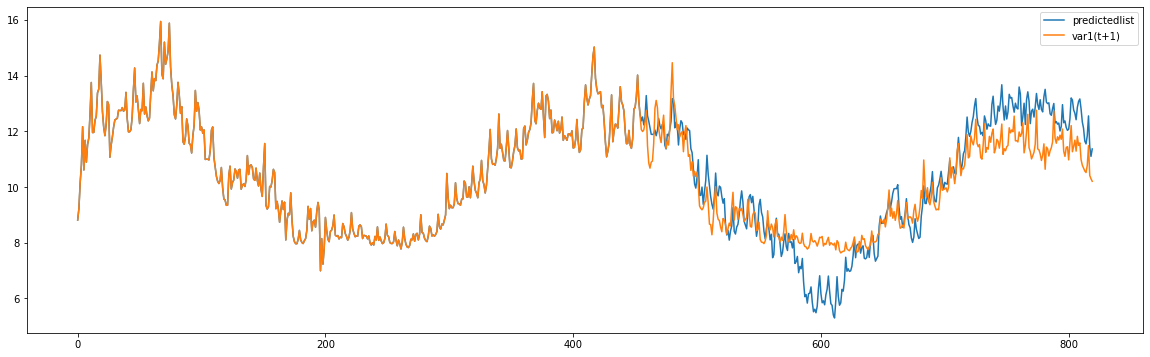

In [611]:
reframed[["predictedlist","var1(t+1)"]].plot(figsize=(20,6));

In [612]:
reframed

,var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var7(t-6),var8(t-6),var9(t-6),var10(t-6),var11(t-6),var12(t-6),var13(t-6),var14(t-6),var15(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var9(t-5),var10(t-5),var11(t-5),var12(t-5),var13(t-5),var14(t-5),var15(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var7(t-4),var8(t-4),var9(t-4),var10(t-4),var11(t-4),var12(t-4),var13(t-4),var14(t-4),var15(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),var11(t-3),var12(t-3),var13(t-3),var14(t-3),var15(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),var11(t-2),var12(t-2),var13(t-2),var14(t-2),var15(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t),var15(t),var1(t+1),predictedlist
0,6.952692,10.0,5.0,0.0,8.7,2.0,16.0,18.0,25.0,90.0,0.0,1027.0,7.0,257.0,0.0,8.536480,13.0,8.0,0.0,8.7,3.0,9.0,30.0,45.0,92.0,0.0,1028.0,10.0,205.0,0.0,9.499781,12.0,7.0,0.0,8.7,2.0,2.0,31.0,44.0,87.0,0.2,1024.0,9.0,240.0,0.0,10.267707,12.0,6.0,0.0,8.2,3.0,5.0,35.0,30.0,90.0,0.0,1026.0,10.0,229.0,1.0,10.850805,12.0,6.0,0.0,6.8,3.0,11.0,36.0,38.0,85.0,0.30,1021.0,10.0,258.0,1.0,9.103382,10.0,5.0,0.0,8.2,3.0,18.0,20.0,36.0,87.0,0.10,1023.0,10.0,197.0,0.0,9.274873,13.0,7.0,0.0,3.1,3.0,25.0,40.0,80.0,90.0,0.50,1010.0,9.0,205.0,0.0,8.813513,8.813513
1,8.536480,13.0,8.0,0.0,8.7,3.0,9.0,30.0,45.0,92.0,0.0,1028.0,10.0,205.0,0.0,9.499781,12.0,7.0,0.0,8.7,2.0,2.0,31.0,44.0,87.0,0.2,1024.0,9.0,240.0,0.0,10.267707,12.0,6.0,0.0,8.2,3.0,5.0,35.0,30.0,90.0,0.0,1026.0,10.0,229.0,1.0,10.850805,12.0,6.0,0.0,6.8,3.0,11.0,36.0,38.0,85.0,0.3,1021.0,10.0,258.0,1.0,9.103382,10.0,5.0,0.0,8.2,3.0,18.0,20.0,36.0,87.0,0.10,1023.0,10.0,197.0,0.0,9.274873,13.0,7.0,0.0,3.1,3.0,25.0,40.0,80.0,90.0,0.50,1010.0,9.0,205.0,0.0,8.813513,11.0,5.0,0.0,6.8,2.0,32.0,32.0,33.0,85.0,0.00,1019.0,10.0,205.0,0.0,9.227707,9.227707
2,9.499781,12.0,7.0,0.0,8.7,2.0,2.0,31.0,44.0,87.0,0.2,1024.0,9.0,240.0,0.0,10.267707,12.0,6.0,0.0,8.2,3.0,5.0,35.0,30.0,90.0,0.0,1026.0,10.0,229.0,1.0,10.850805,12.0,6.0,0.0,6.8,3.0,11.0,36.0,38.0,85.0,0.3,1021.0,10.0,258.0,1.0,9.103382,10.0,5.0,0.0,8.2,3.0,18.0,20.0,36.0,87.0,0.1,1023.0,10.0,197.0,0.0,9.274873,13.0,7.0,0.0,3.1,3.0,25.0,40.0,80.0,90.0,0.50,1010.0,9.0,205.0,0.0,8.813513,11.0,5.0,0.0,6.8,2.0,32.0,32.0,33.0,85.0,0.00,1019.0,10.0,205.0,0.0,9.227707,11.0,5.0,0.0,4.9,2.0,39.0,25.0,78.0,90.0,7.25,1007.0,9.0,143.0,0.0,10.145910,10.145910
3,10.267707,12.0,6.0,0.0,8.2,3.0,5.0,35.0,30.0,90.0,0.0,1026.0,10.0,229.0,1.0,10.850805,12.0,6.0,0.0,6.8,3.0,11.0,36.0,38.0,85.0,0.3,1021.0,10.0,258.0,1.0,9.103382,10.0,5.0,0.0,8.2,3.0,18.0,20.0,36.0,87.0,0.1,1023.0,10.0,197.0,0.0,9.274873,13.0,7.0,0.0,3.1,3.0,25.0,40.0,80.0,90.0,0.5,1010.0,9.0,205.0,0.0,8.813513,11.0,5.0,0.0,6.8,2.0,32.0,32.0,33.0,85.0,0.00,1019.0,10.0,205.0,0.0,9.227707,11.0,5.0,0.0,4.9,2.0,39.0,25.0,78.0,90.0,7.25,1007.0,9.0,143.0,0.0,10.145910,7.0,3.0,0.0,8.1,2.0,45.0,21.0,35.0,91.0,7.25,1012.0,9.0,254.0,0.0,10.780273,10.780273
4,10.850805,12.0,6.0,0.0,6.8,3.0,11.0,36.0,38.0,85.0,0.3,1021.0,10.0,258.0,1.0,9.103382,10.0,5.0,0.0,8.2,3.0,18.0,20.0,36.0,87.0,0.1,1023.0,10.0,197.0,0.0,9.274873,13.0,7.0,0.0,3.1,3.0,25.0,40.0,80.0,90.0,0.5,1010.0,9.0,205.0,0.0,8.813513,11.0,5.0,0.0,6.8,2.0,32.0,32.0,33.0,85.0,0.0,1019.0,10.0,205.0,0.0,9.227707,11.0,5.0,0.0,4.9,2.0,39.0,25.0,78.0,90.0,7.25,1007.0,9.0,143.0,0.0,10.145910,7.0,3.0,0.0,8.1,2.0,45.0,21.0,35.0,91.0,7.25,1012.0,9.0,254.0,0.0,10.780273,10.0,6.0,0.0,4.9,2.0,52.0,36.0,60.0,91.0,7.25,1004.0,9.0,240.0,1.0,12.163127,12.163127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

Text(0.5, 0, 'Time')

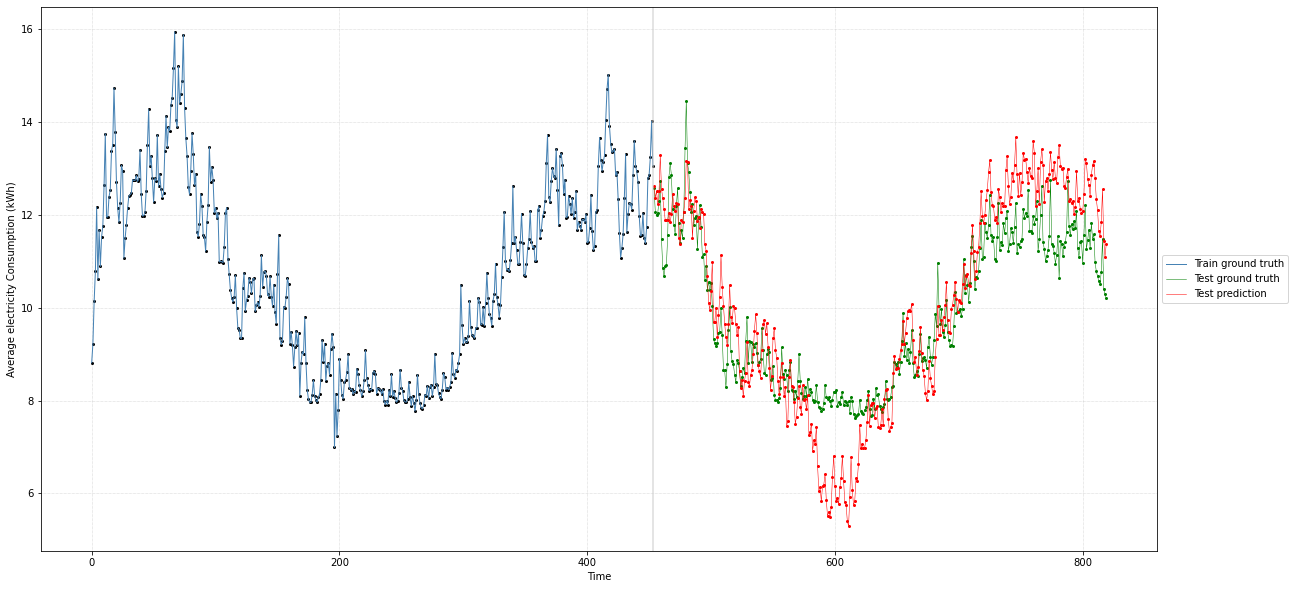

In [613]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1, figsize=(20, 10), sharex=True)

train = reframed[:454]
axes.plot(train.index, train['var1(t+1)'], 'ko', markersize=2, )
axes.plot(train.index, train['var1(t+1)'], color='steelblue', lw=1,label='Train ground truth')

test = reframed[454:]
axes.plot(test.index, test['var1(t+1)'], 'go', markersize=2, )
axes.plot(test.index, test['var1(t+1)'], 'g', lw=0.5, label='Test ground truth')
axes.plot(test.index, test.predictedlist, color='red', lw=0.5, label='Test prediction')
axes.plot(test.index, test.predictedlist, 'ro', markersize=2, )

axes.axvline(train.index[-1], color='0.8', alpha=0.7)
axes.set_ylabel(f'Average electricity Consumption (kWh)')
axes.grid(ls=':', lw=0.5)
axes.legend(loc='center left', bbox_to_anchor=(1,0.5))
axes.set_xlabel('Time')

In [614]:
import numpy as np
from sklearn.metrics import mean_absolute_error


print(mean_absolute_error(y_true, pred_list))

0.782141425763812


In [615]:
#import the libraries for error calculation
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

#Calculate error of the model with RMSE, MSE, MAE, MAPE
print("RMSE: ",mean_squared_error(y_true, pred_list))
print("MSE: ",mean_squared_error(y_true, pred_list, squared=False))
print("MAE: ",mean_absolute_error(y_true, pred_list))
print("MAPE: ",mean_absolute_percentage_error(y_true, pred_list))

RMSE:  0.964096644432023
MSE:  0.9818842316851937
MAE:  0.782141425763812
MAPE:  0.08125696362238086


In [616]:
weather_energy[806:807]

,avg_energy,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,WindGustKmph,cloudcover,humidity,precipMM,pressure,visibility,winddirDegree,IsBankHoliday
day,,,,,,,,,,,,,,,
2014-02-06,11.445403,8.0,5.0,0.0,3.5,2.0,43.0,39.0,67.0,92.0,7.25,990,9.0,188,0
